# Signal Processing
## Week \#9 Lab: Spectral Analysis

### Introduction

The discrete Fourier transform (DFT) is the primary computational tool for spectral analysis. In this assignment, we use the DFT through an efficient implementation of the FFT algorithm to analyze a signal's frequency content. We investigate the effects of windowing the signal, which is required to compute a finite-length DFT. We then use the short-time Fourier transform to analyze signals that change over time by visualizing the spectrogram.

### Install Python Packages

Import the necessary Python modules to implement the lab.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import fft
import scipy.io

### Time-Windowing and the DFT

We previously used the __[`scipy.fft`](https://docs.scipy.org/doc/scipy/reference/fft.html)__ module (or __[`numpy.fft`](https://numpy.org/doc/stable/reference/routines.fft.html)__) since it contains various DFT functions that use Fast Fourier Transform (FFT) algorithms to compute the DFT and inverse DFT.

The DFT represents a finite-length sequence with discrete frequency components and provides an important computational tool for working with signals. Here is the definition of the N-point DFT where there are $N$ frequency samples spaced by $2\pi/N$ and indexed by $k$:

\begin{equation*}
X[k] = \sum\limits_{n=0}^{N-1}x[n] e^{-j2\pi kn /N}\quad 0 \leq k \leq N-1
\end{equation*}

Selecting a finite number of samples in the above computation of the DFT is equivalent to multiplying the longer signal $x[n]$, which is defined from $-\infty < n < \infty$, by a rectangular data window, $w[n]$, of a finite length $L$:

\begin{equation*}
	w[n] =
	\begin{cases}
		1, & 0 \leq n \leq L-1\\
		0, & \text{ otherwise}
	\end{cases}
\end{equation*}

Therefore, the DFT provides samples of the DTFT of the time-windowed sequence $w[n]x[n]$, not the original sequence. One effect of this windowing is spectral spreading or smearing, which limits the ability to resolve distinct spectral peaks. Another effect of this windowing is spectral leakage, in which power from one frequency band is transferred to another. We can visualize these effects of time multiplication by a window through the convolution of the signal's Fourier transform with the window's Fourier transform.

For a given window length ($L$), the rectangular window spectrum has the narrowest main lobe, which will lead to the best spectral resolution or the ability to distinguish two distinct spectral peaks that are close in frequency. The trade-off is that the rectangular window spectrum has the largest relative side lobes and, therefore, the most spectral leakage. This will create false peaks and change the amplitudes of existing peaks, which might include burying existing signals with small relative amplitudes compared to other signals. Using other time-domain windows, such as Bartlett, Hanning, and Hamming, will reduce the side lobes at the expense of increasing the main lobe width. SciPy contains a variety of window functions for use in the spectral analysis of signals with __[`scipy.signal.windows`](https://docs.scipy.org/doc/scipy/reference/signal.windows.html)__.

#### Example: DFT of Two Sinusoids

In the example below, we investigate the DFT of two sinusoids using a rectangular and a Hamming window. The resulting DFT magnitude of these two signals depends on the time window. You can adjust the difference in frequency of these two sinusoids and/or the amplitude of the sinusoids to observe how using different windows will provide a different frequency domain representation.

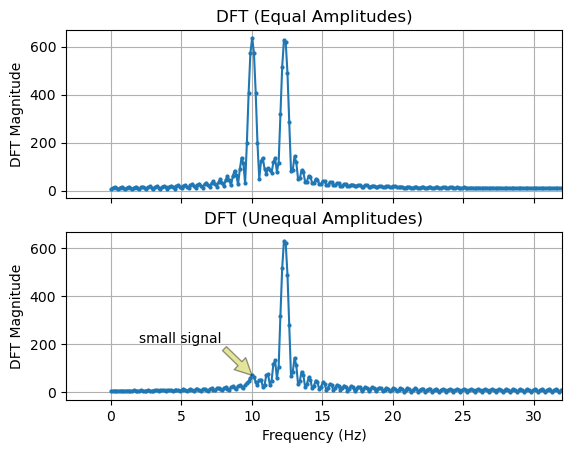

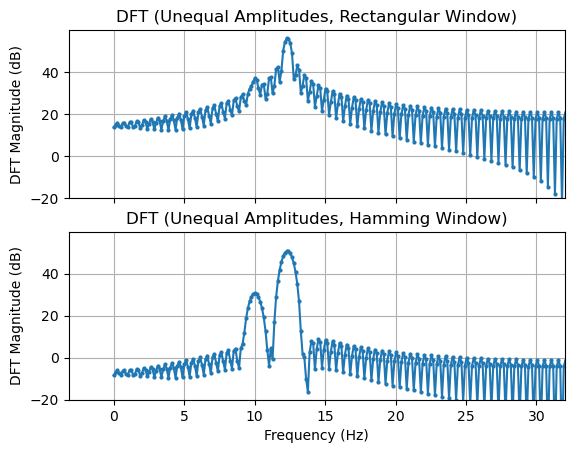

In [ ]:
# Example: DFT of Two Sinusoids

# define parameters
Fs = 64 # sample frequency
nT = np.arange(0,2,1/Fs)
f = 10 # frequency of first component
deltaf = 2.3 # frequency distance to the second component
N = 512 # length of DFT

# define signals
x1 = 10*np.cos(2*np.pi*f*nT) + 10*np.cos(2*np.pi*(f+deltaf)*nT)
x2 = np.cos(2*np.pi*f*nT) + 10*np.cos(2*np.pi*(f+deltaf)*nT)

# DFT of signals
X1dft = fft.fft(x1, N)
X2dft = fft.fft(x2, N)

# Plot DFTs (plotting only the first half of the DFT, positive frequencies)
fig, [ax0, ax1] = plt.subplots(2, 1, sharex=True, sharey=True)
ax0.plot(np.linspace(0,Fs,len(X1dft)), np.abs((X1dft)),'-o',markersize=2)
ax0.set_title('DFT (Equal Amplitudes)')
ax0.set_ylabel('DFT Magnitude')
ax0.set_xlim(xmax = Fs/2)
ax0.grid()
ax1.plot(np.linspace(0,Fs,len(X2dft)), np.abs((X2dft)),'-o',markersize=2)
ax1.set_title('DFT (Unequal Amplitudes)')
ax1.set_ylabel('DFT Magnitude')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_xlim(xmax = Fs/2)
ax1.grid()

# annotate plot
ax1.annotate('small signal', xy=(f,abs(X2dft)[int(f/Fs*N)]),
             xytext=(2,205), arrowprops={'facecolor':'y','alpha':.4});

# time-windowing with rectangular (default) and Hamming windows
HammingWindow = signal.windows.hamming(len(x1))
x1Hamming = x1 * HammingWindow
x2Hamming = x2 * HammingWindow

# DFT of windowed sequence
X1dftHamming = fft.fft(x1Hamming, N)
X2dftHamming = fft.fft(x2Hamming, N)

# Plot DFTs (plotting only the first half of the DFT, positive frequencies)
fig, [ax0, ax1] = plt.subplots(2, 1, sharex=True, sharey=True)
ax0.plot(np.linspace(0,Fs,len(X2dft)), 20*np.log10(np.abs((X2dft))),'-o',markersize=2)
ax0.set_title('DFT (Unequal Amplitudes, Rectangular Window)')
ax0.set_ylabel('DFT Magnitude (dB)')
ax0.set_xlim(xmax = Fs/2)
ax1.set_ylim(ymin = -20)
ax0.grid()
ax1.plot(np.linspace(0,Fs,len(X2dftHamming)), 20*np.log10(np.abs((X2dftHamming))),'-o',markersize=2)
ax1.set_title('DFT (Unequal Amplitudes, Hamming Window)')
ax1.set_ylabel('DFT Magnitude (dB)')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_xlim(xmax = Fs/2)
ax1.set_ylim(ymin = -20)
ax1.grid()

### Short-Time Fourier Transform and the Spectrogram for Time-Varying Signals

Since many signals of interest have spectral characteristics that change with time, using a sequence of short overlapping DFTs to capture these changes is known as a short-time Fourier transform (STFT). This collection of DTFTs parameterized by the discrete starting time index ($n$) and the continuous frequency variable ($\lambda$) leads to a spectrogram displayed as a two-dimensional contour plot. Mixed brackets are used in the equation for the short-time Fourier transform below to emphasize discrete and continuous variables.

\begin{equation*}
X \left[ n, \lambda \right) = \sum_{m=\infty}^{\infty} x[n+m] w[m] e^{-j\lambda m}
\end{equation*}

Using the DFT and block shifting of the time index,leads to a sampled short-time Fourier transform to compute the spectrogram:
\begin{equation*}
X[rR, k] = X[rR, 2\pi k / N ] = \sum_{m=0}^{L-1}x[rR+m] w[m] e^{-j(2\pi / N )km}
\end{equation*}
\begin{equation*}
r, k \text{ are integers:} \quad -\infty < r < \infty, \quad 0 \leq k \leq N-1
\end{equation*}
\begin{equation*}
\text{window: } w[m] =0 \quad \text{outside the interval } 0 \leq m \leq L-1
\end{equation*}

SciPy has a class __[`scipy.signal.ShortTimeFFT`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ShortTimeFFT.html)__ that contains functions  __[`scipy.signal.ShortTimeFFT.stft`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ShortTimeFFT.stft.html)__ and  __[`scipy.signal.ShortTimeFFT.spectrogram`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.ShortTimeFFT.spectrogram.html)__. A discussion is in the __[tutorial](https://docs.scipy.org/doc/scipy/tutorial/signal.html#tutorial-stft)__ on the short-time Fourier transform.

#### Example: Spectrogram

In this example, we plot the spectrogram of a linear chirp signal, a signal whose frequency changes linearly over time. Here we use the legacy function __[`scipy.signal.spectrogram`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html)__ to compute a spectrogram to ensure compatibility with older versions of SciPy.

Text(0.5, 0, 'Time (sec)')

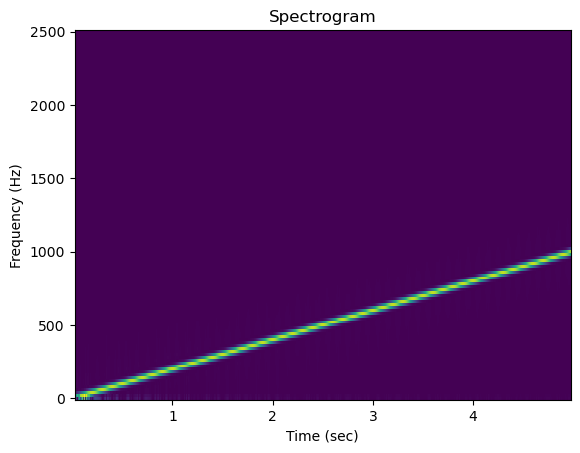

In [ ]:
# Define linear chirp signal
Fs = 5000 # sample frequency
nT = np.arange(0,5,1/Fs)
x = signal.chirp(nT,0,5,1000,method='linear')

# Compute and plot spectrogram
window_length = 250
Hammwindow = signal.windows.hamming(window_length) # create window for use in STFT
f, t, STFT = signal.spectrogram(x,fs=Fs,window=Hammwindow,noverlap = window_length - 1,mode='magnitude')
fig, ax = plt.subplots()
ax.pcolormesh(t,f, STFT)
ax.set_title('Spectrogram')
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (sec)')


## Exercises

#### *Insert Your Name Here:*

### Exercise \#1

Create the following signal

\begin{equation*}
x[n] = \cos \left( 2\pi Cn/N \right)
\end{equation*}

Where $C=1$, $N=16$, and $0 \leq n \leq N-1$. Use a stem plot to visualize this signal in the time domain. Compute this signal's 16-point discrete Fourier transform using the FFT and plot the magnitude of the DFT using a stem plot. Repeat this for $C=2$ and $C=3$. Explain your results. How many full cycles are in these finite-length sinusoidal sequences, and which terms in DFT are non-zero and why?

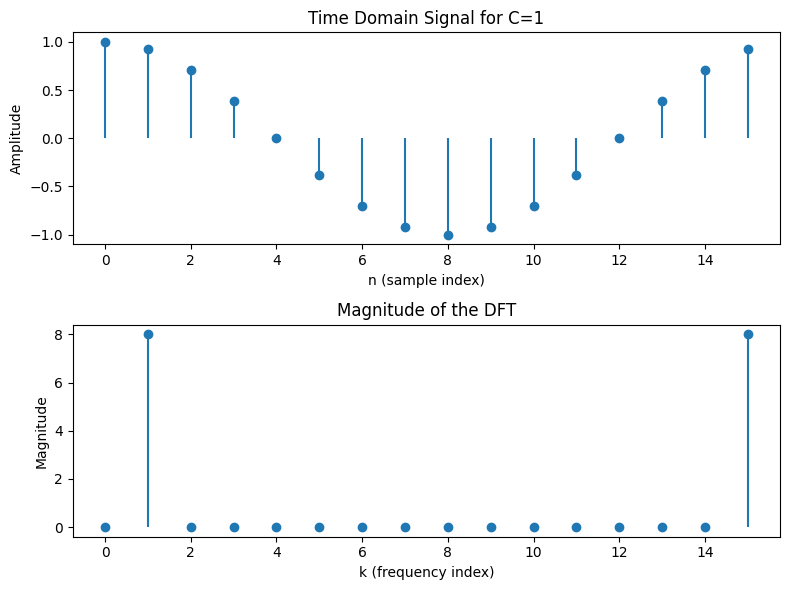

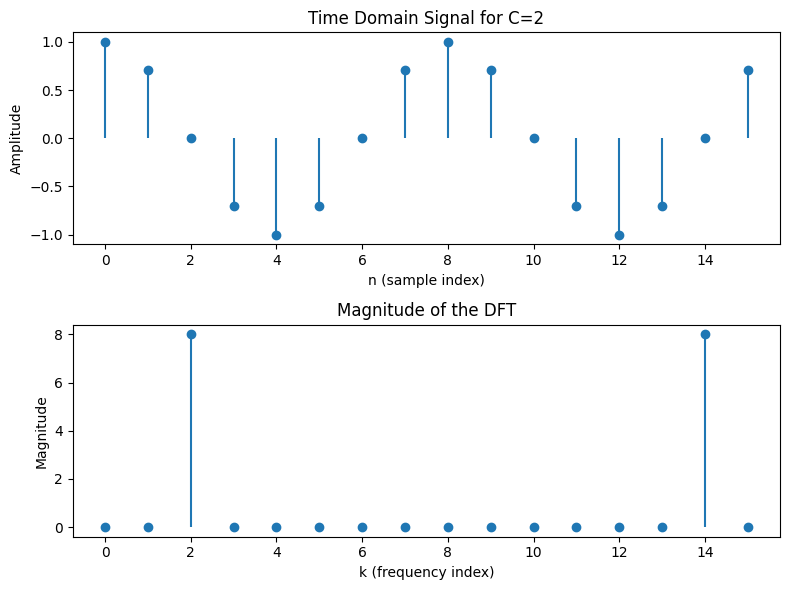

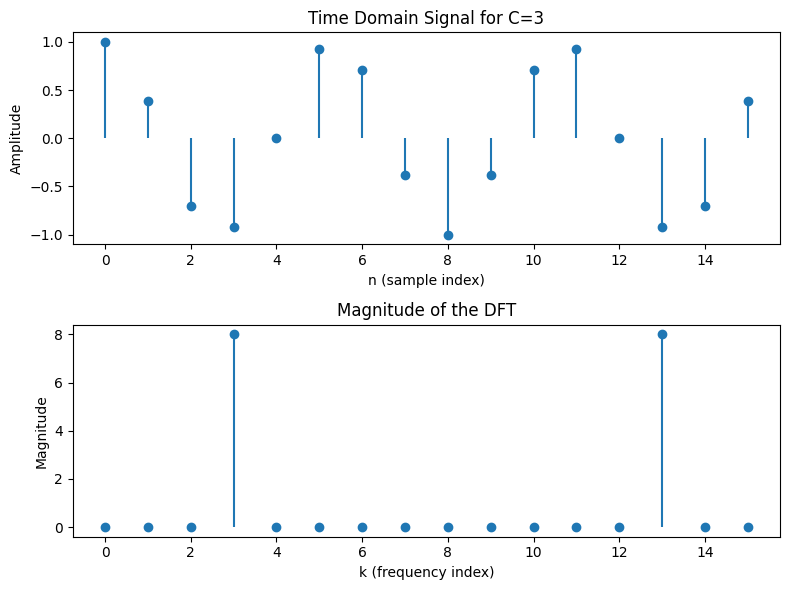

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft

# Define constants
N = 16  # Length of the DFT

# Helper function to plot the time domain signal and its DFT magnitude
def plot_signal_and_dft(C):
    n = np.arange(N)  # Time index
    x = np.cos(2 * np.pi * C * n / N)  # Signal definition

    # Compute the DFT using FFT
    X = fft(x, N)

    # Create figure for plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

    # Time domain plot
    ax1.stem(n, x, basefmt=" ")
    ax1.set_title(f'Time Domain Signal for C={C}')
    ax1.set_xlabel('n (sample index)')
    ax1.set_ylabel('Amplitude')

    # Frequency domain plot
    ax2.stem(np.arange(N), np.abs(X), basefmt=" ")
    ax2.set_title('Magnitude of the DFT')
    ax2.set_xlabel('k (frequency index)')
    ax2.set_ylabel('Magnitude')

    # Show plots
    plt.tight_layout()
    plt.show()

# Plot for C = 1, C = 2, C = 3
for C in [1, 2, 3]:
    plot_signal_and_dft(C)


### Explanation:
- The function `plot_signal_and_dft` takes a parameter $ C $, computes the cosine signal $ x[n] = \cos\left(2\pi Cn/N\right) $ for $ n $ ranging from 0 to $ N-1 $, and then computes its DFT using FFT.
- The stem plots are used to visualize the time-domain signal and the magnitude of its DFT.
- This function is called sequentially for $ C=1 $, $ C=2 $, and $ C=3 $. Each call generates a new figure with two subplots: one for the time-domain signal and one for the magnitude of the DFT.


### Exercise \#2

Continuing with the same discrete-time signal as before:

\begin{equation*}
x[n] = \cos \left( 2\pi Cn/N \right)
\end{equation*}

1. Now let $N=1024$, $C=10$, and $0 \leq n \leq N-1$. Shift from stem to plot for the following figures due to the increased number of samples in time and frequency. Compute the 1024-point DFT. Once again, plot the time-domain sequence and the DFT magnitude. Explain your results (including how large the spectral peaks are).
2. Now change $C$ to $C=10.5$ and plot the time-domain sequence and DFT magnitude. Explain your results.
3. Since we haven't explicitly used a time-domain window, the finite-length sequence used in the DFT is equivalent to multiplying the signal by a rectangular window. We can use a different window to mitigate some of the effects of the rectangular window. Multiply the signal by a Hanning window of length $N$ and explain how your DFT magnitude results have changed and why.

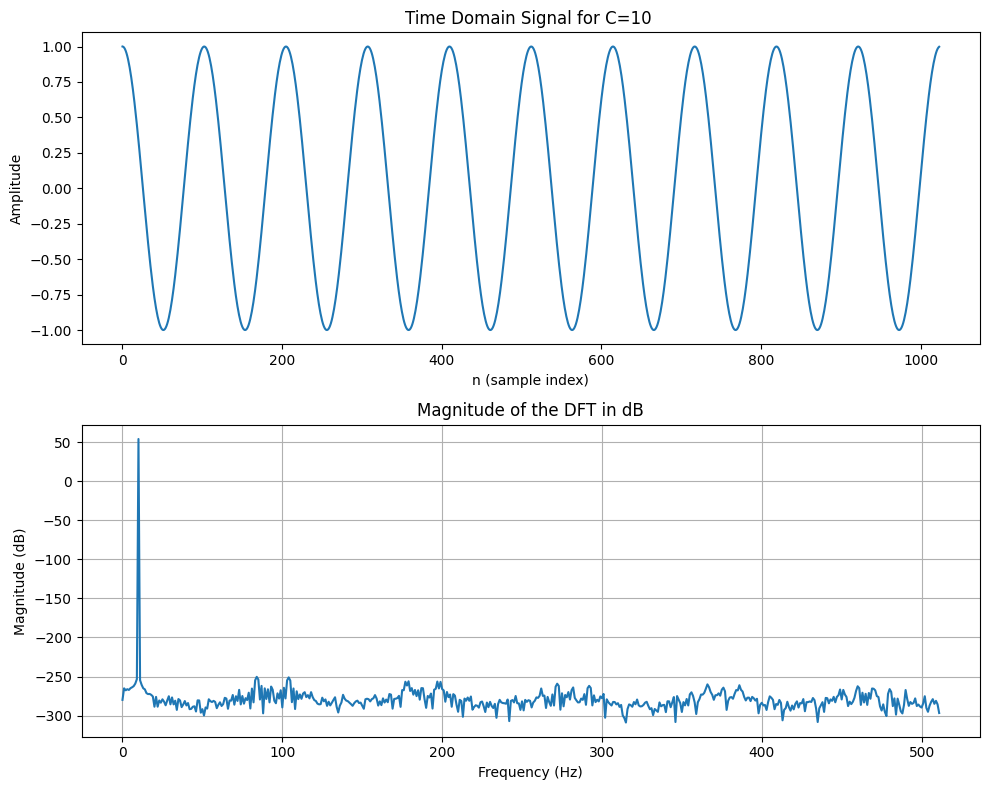

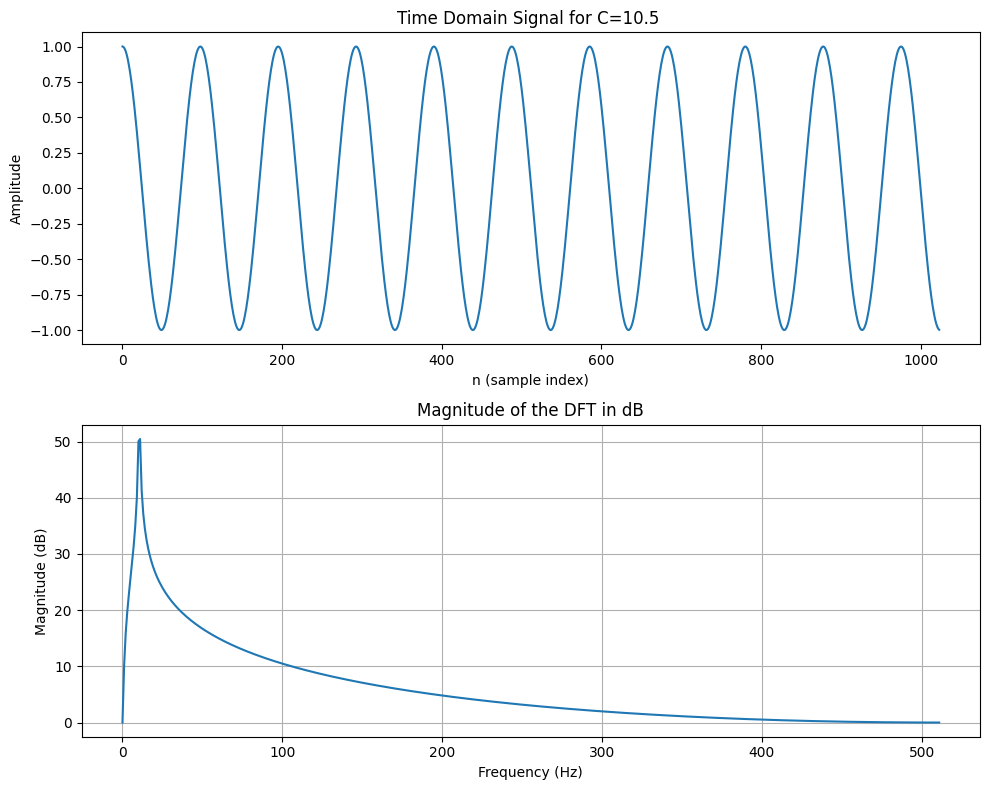

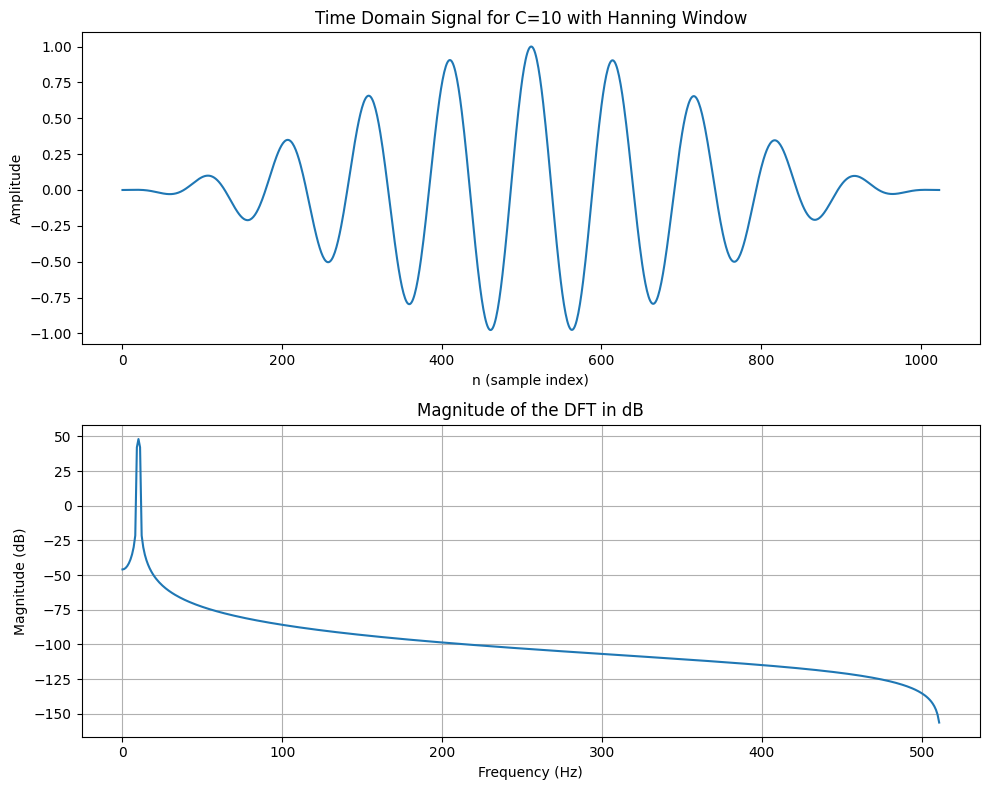

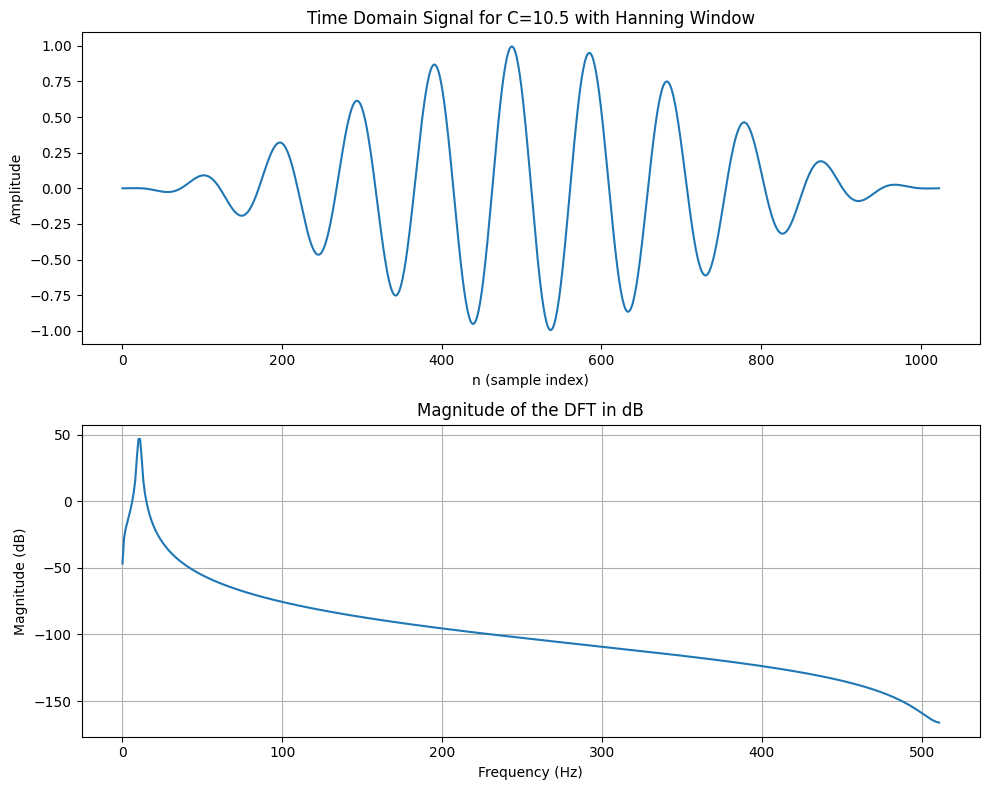

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import windows

# Define constants
N = 1024  # Length of the DFT

# Helper function to compute and plot signal and its DFT
def analyze_signal(C, use_window=False):
    n = np.arange(N)
    x = np.cos(2 * np.pi * C * n / N)

    if use_window:
        window = windows.hann(N)
        x *= window  # Apply the Hanning window

    # Compute the DFT using FFT
    X = fft(x, N)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    ax1.plot(n, x)
    ax1.set_title(f'Time Domain Signal for C={C} {"with Hanning Window" if use_window else ""}')
    ax1.set_xlabel('n (sample index)')
    ax1.set_ylabel('Amplitude')

    # Only plot positive frequencies and convert to dB scale
    freqs = np.fft.fftfreq(N, 1/N)[:N//2]
    magnitude_dB = 20 * np.log10(np.abs(X[:N//2]))
    ax2.plot(freqs, magnitude_dB)
    ax2.set_title('Magnitude of the DFT in dB')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Magnitude (dB)')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Analyze for C=10 without window
analyze_signal(10)

# Analyze for C=10.5 without window
analyze_signal(10.5)

# Analyze for C=10 with Hanning window
analyze_signal(10, use_window=True)

# Analyze for C=10.5 with Hanning window
analyze_signal(10.5, use_window=True)



### Explanation:
- The function `analyze_signal` computes a cosine signal for a given value of $ C $ and optionally applies a Hanning window if `use_window` is set to `True`.
- The DFT of the signal is computed using FFT, and its magnitude is plotted in decibels (dB) to better visualize the spectral content, especially when the signal components have significantly different amplitudes.
- The plots are generated for both $ C=10 $ and $ C=10.5 $ with and without a window to show the effect of windowing on spectral leakage and resolution.


### Exercise \#3

There is an unknown signal in the signal.mat file. Load this signal into your workspace Jupyter Notebook workspace:

`newsignal = scipy.io.loadmat("signal.mat",struct_as_record=False, squeeze_me=True)`

`newsignal = np.array(newsignal['signal'])`

This will create a variable called `newsignal` that contains 1024 data points of this unknown signal. Using the DFT for spectral analysis, determine the number of frequency components in this signal and their relative signal strengths. Remember the effects of using windows in spectral analysis so you don't underestimate the frequency components in this signal. Using a log-magnitude plot (dB) for the DFT may be helpful in identifying any lower strength signals with the appropriate window. Explain your results and how you found the number of frequency components in this unknown signal.

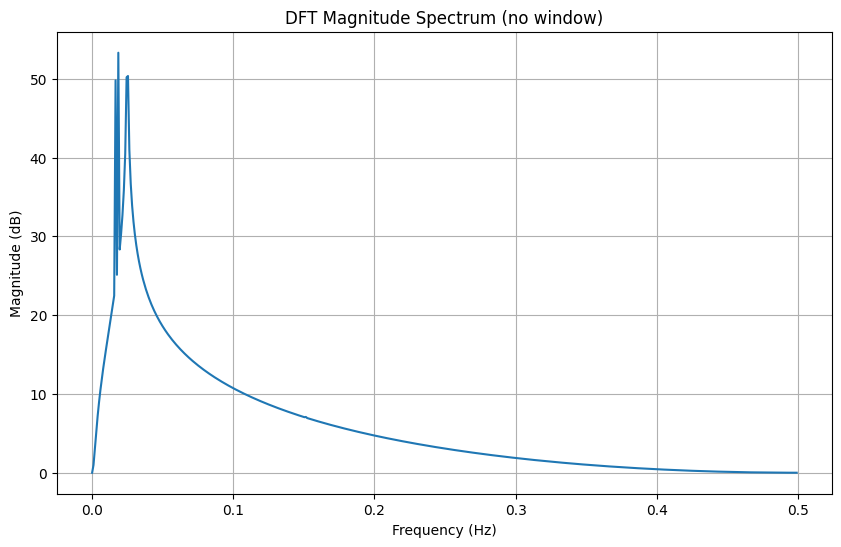

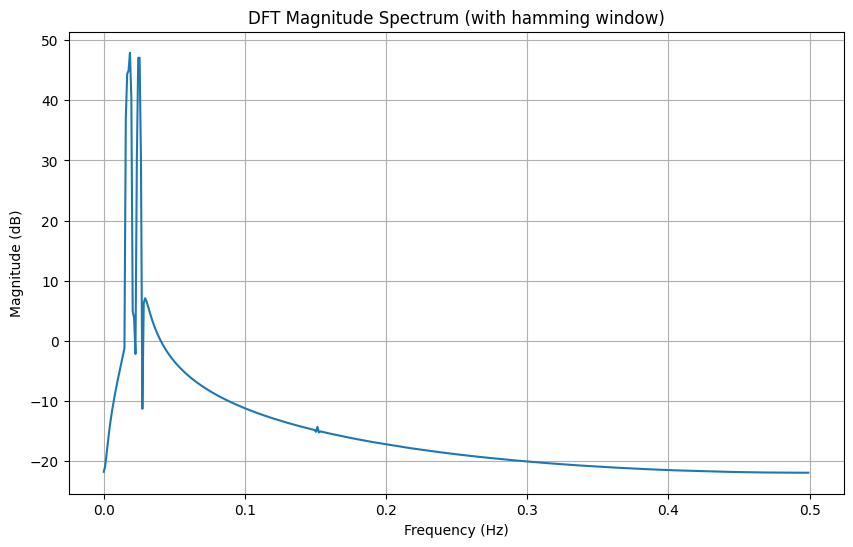

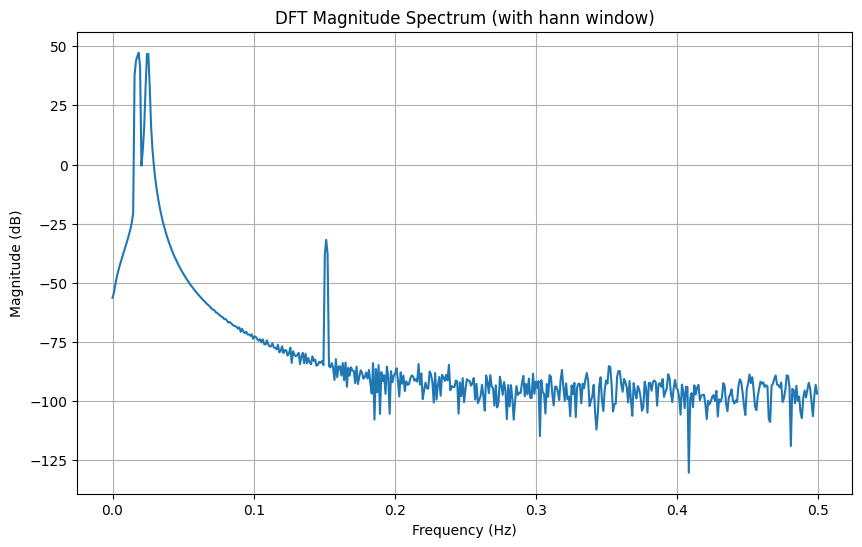

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.io import loadmat
from scipy.signal import windows

# Load the signal from the MATLAB file
data = loadmat("signal.mat", struct_as_record=False, squeeze_me=True)
newsignal = np.array(data['signal'])

# Constants
N = len(newsignal)  # Assuming the signal length is 1024 as mentioned

# Function to analyze the signal
def analyze_unknown_signal(signal, use_window=None):
    if use_window:
        window = use_window(len(signal))
        signal = signal * window

    # Compute the DFT
    X = fft(signal)

    # Frequencies for plotting (only positive frequencies)
    freqs = np.fft.fftfreq(N, 1)[:N//2]

    # Convert to dB
    magnitude_dB = 20 * np.log10(np.abs(X[:N//2]))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(freqs, magnitude_dB)
    plt.title(f'DFT Magnitude Spectrum ({"with " + use_window.__name__ + " window" if use_window else "no window"})')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.grid(True)
    plt.show()

# Analyze without any window
analyze_unknown_signal(newsignal)

# Analyze with a Hamming window
analyze_unknown_signal(newsignal, use_window=windows.hamming)

# Analyze with a Hanning window
analyze_unknown_signal(newsignal, use_window=windows.hann)


### Exercise \#4
Create the following discrete-time signal. Plot spectrograms using rectangular and Hamming windows of length 401 and 101. Explain your results. Use Example 10.10 from the Oppenheim and Schafer textbook as a guide.
\begin{equation*}
	x[n] =
	\begin{cases}
		\cos\left[(15\pi\times 10^{-6}) n^2\right] & 0 \leq n \leq 20000\\
		\cos(0.2 \pi n) , & 20000 < n \leq 25000\\
		\cos(0.2 \pi n) + \cos(0.23 \pi n) ,& 25000 < n \leq 30000
	\end{cases}
\end{equation*}


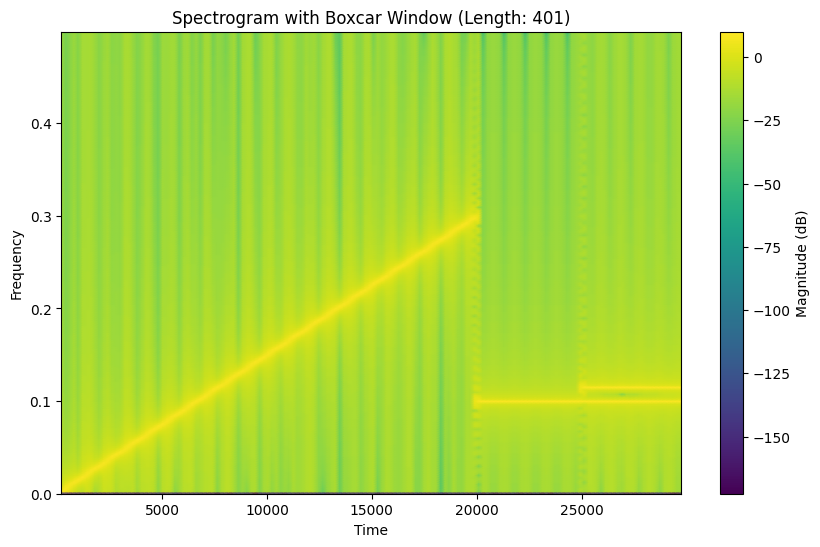

<ipython-input-5-db7bfaf77338>:23: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  window = window_type(window_length)


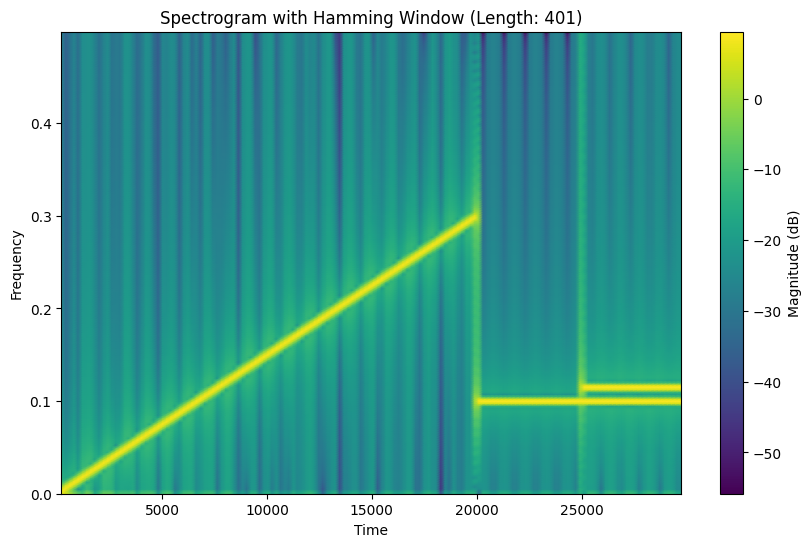

<ipython-input-5-db7bfaf77338>:27: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')


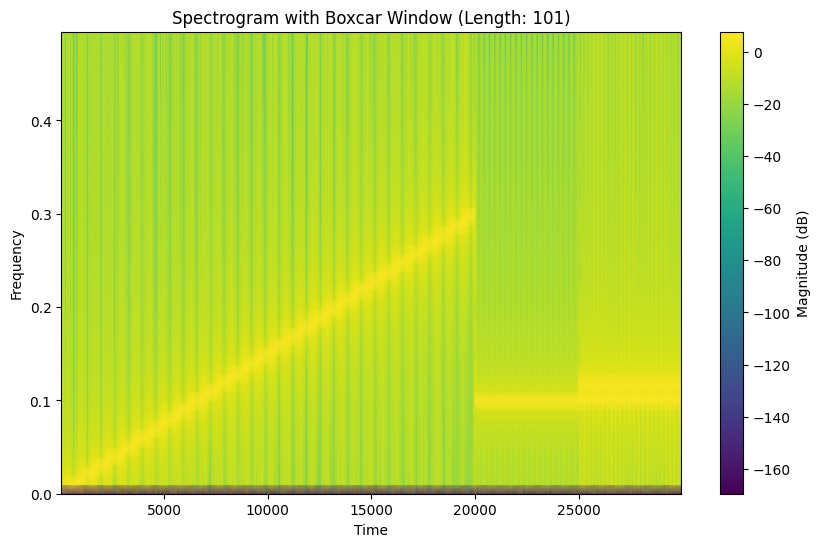

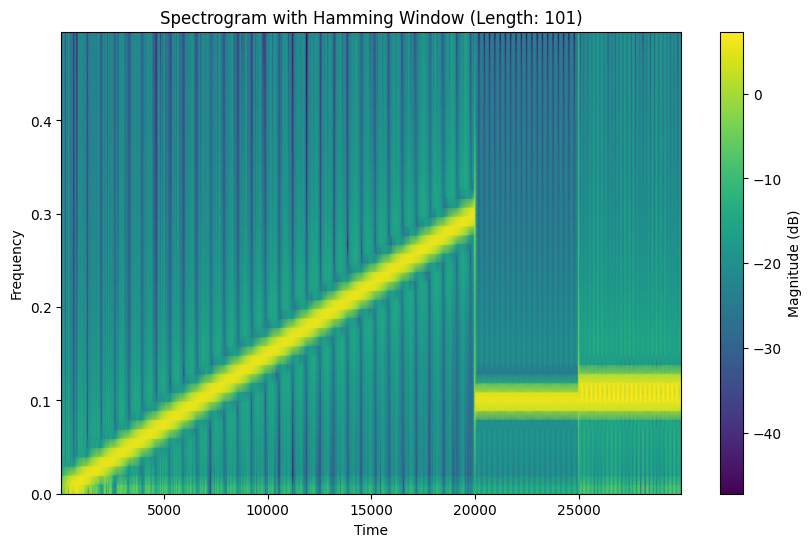

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram, hamming, windows

# Define the signal function
def create_signal(n):
    if n <= 20000:
        return np.cos((15 * np.pi * 1e-6) * n ** 2)
    elif n <= 25000:
        return np.cos(0.2 * np.pi * n)
    else:
        return np.cos(0.2 * np.pi * n) + np.cos(0.23 * np.pi * n)

# Create the signal vector
n = np.arange(30001)
x = np.vectorize(create_signal)(n)

# Define parameters for spectrogram
Fs = 1  # Sampling frequency, arbitrary since time unit not defined

# Helper function to plot spectrogram with given window size and type
def plot_spectrogram(window_type, window_length):
    window = window_type(window_length)
    f, t, Sxx = spectrogram(x, fs=Fs, window=window, nperseg=window_length, noverlap=window_length // 2, mode='magnitude')

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label='Magnitude (dB)')
    plt.title(f'Spectrogram with {window_type.__name__.capitalize()} Window (Length: {window_length})')
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.show()

# Plot spectrograms using rectangular and Hamming windows of length 401 and 101
plot_spectrogram(windows.boxcar, 401)  # Rectangular window of length 401
plot_spectrogram(hamming, 401)        # Hamming window of length 401
plot_spectrogram(windows.boxcar, 101)  # Rectangular window of length 101
plot_spectrogram(hamming, 101)        # Hamming window of length 101



### Explanation:
- **Signal Definition**: The signal $ x[n] $ is defined piecewise for different intervals of $ n $. This code utilizes the `np.vectorize` function to apply the piecewise definition efficiently across an array of time indices.
- **Spectrogram Computation**: The `plot_spectrogram` function computes and plots the spectrogram of the signal using different window types and lengths. The `spectrogram` function from `scipy.signal` is used to calculate the Short-Time Fourier Transform (STFT) of the signal. The function plots the magnitude of the spectrogram in decibels.
- **Window Types**: The function handles both the rectangular (`windows.boxcar`) and Hamming (`hamming`) windows. The `nperseg` parameter is the length of each segment of the signal used in the STFT, which corresponds to the window length. The `noverlap` parameter is set to half the window length, providing 50% overlap between consecutive segments.
